In [1]:
import pandas as pd

In [2]:
# Get Data
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.isnull().sum().sum()

0

In [5]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [7]:
# Reset index in df1 with close column
df1=df.reset_index()['Close']

In [9]:
df1

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

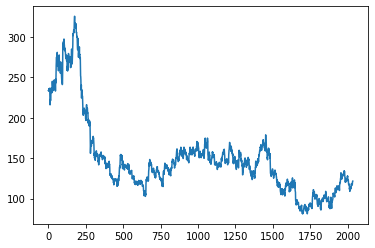

In [8]:
# Plot Close Column Data
import matplotlib.pyplot as plt
plt.plot(df1)

### LSTM are sensitive to the scale of the data. so we apply MinMax scaler / Standard Scalar

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [13]:
df1

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [28]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.70)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [15]:
training_size,test_size

(1424, 611)

In [29]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	X_train, y_train = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		X_train.append(a)
		y_train.append(dataset[i + time_step, 0])
	return np.array(X_train), np.array(y_train)

In [36]:
# Create Dataset matric with 100 timestep
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [41]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(1323, 100)
(1323,)

(510, 100)
(510,)


In [42]:
# reshape input that is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [46]:
### Import Libraries for Stacked LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [47]:
# Create Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Train model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 15s 275ms/step - loss: 0.0256 - val_loss: 0.0063
Epoch 2/100
21/21 [==============================] - 4s 196ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 3/100
21/21 [==============================] - 4s 194ms/step - loss: 0.0017 - val_loss: 9.4081e-04
Epoch 4/100
21/21 [==============================] - 4s 192ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/100
21/21 [==============================] - 4s 194ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/100
21/21 [==============================] - 4s 197ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
21/21 [==============================] - 4s 196ms/step - loss: 0.0014 - val_loss: 7.7703e-04
Epoch 8/100
21/21 [==============================] - 4s 196ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 9/100
21/21 [==============================] - 4s 197ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
21/21 [==============================] - 4s 198ms/step - loss: 0.0011

In [49]:
# Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [50]:
#Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [51]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

165.49279685859176

In [53]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

108.67765670337239

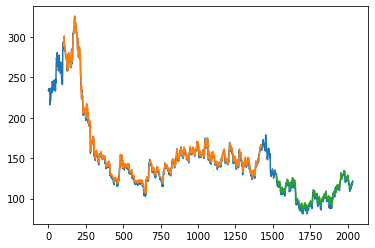

In [59]:
# Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predict for next days

In [60]:
len(test_data)

611

In [63]:
x_input=test_data[511:].reshape(1,-1)
x_input.shape

(1, 100)

In [64]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [69]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.17062691]
101
1 day input [0.13848039 0.14011438 0.13888889 0.13541667 0.14011438 0.1380719
 0.13071895 0.13071895 0.12867647 0.11846405 0.14644608 0.14808007
 0.15910948 0.15992647 0.15788399 0.16441993 0.17892157 0.17933007
 0.19260621 0.20812908 0.18974673 0.18055556 0.18239379 0.17708333
 0.17810458 0.18055556 0.17810458 0.17851307 0.19607843 0.18913399
 0.18954248 0.19403595 0.19444444 0.20200163 0.19771242 0.19934641
 0.19873366 0.1997549  0.2128268  0.21568627 0.20445261 0.21772876
 0.21098856 0.21425654 0.19750817 0.18811275 0.17851307 0.17381536
 0.16033497 0.16564542 0.17116013 0.17422386 0.18035131 0.17401961
 0.16278595 0.16973039 0.17810458 0.17034314 0.16830065 0.17279412
 0.17544935 0.18382353 0.19138072 0.18913399 0.19097222 0.17238562
 0.16830065 0.1693219  0.17177288 0.16156046 0.14971405 0.1503268
 0.15196078 0.14726307 0.14501634 0.14603758 0.12479575 0.13112745
 0.11397059 0.1190768  0.12377451 0.13562092 0.12908497 0.13459967
 0.12806373 0.13031046 0.12724673 0

In [70]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [71]:
len(df1)

2035

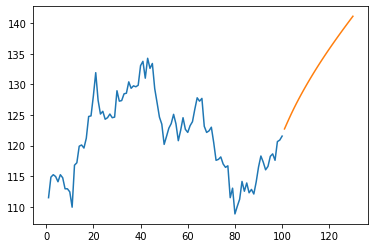

In [72]:
plt.plot(day_new,scaler.inverse_transform(df1[1935:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

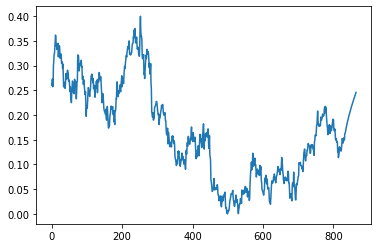

In [76]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

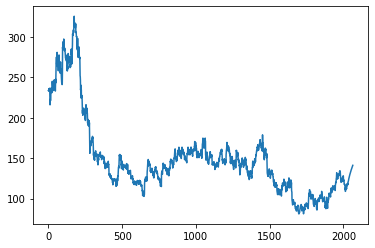

In [74]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)